In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data.csv')

# single columns
for i, d in enumerate(['x0', 'x1', 'y0', 'y1', 'z0', 'z1']):
    df[d] = df['bbox'].apply(lambda t: eval(t)[i // 2][i % 2])

In [3]:
df['organ_volume'] = (df['x1'] - df['x0']) * (df['y1'] - df['y0']) * (df['z1'] - df['z0'])
df['organ_area_axial']= (df['x1'] - df['x0']) * (df['y1'] - df['y0'])
df['organ_area_coronal']= (df['x1'] - df['x0']) * (df['z1'] - df['z0'])
df['organ_area_sagittal']= (df['y1'] - df['y0']) * (df['z1'] - df['z0'])

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

/tmp/ipykernel_20504/2170546020.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


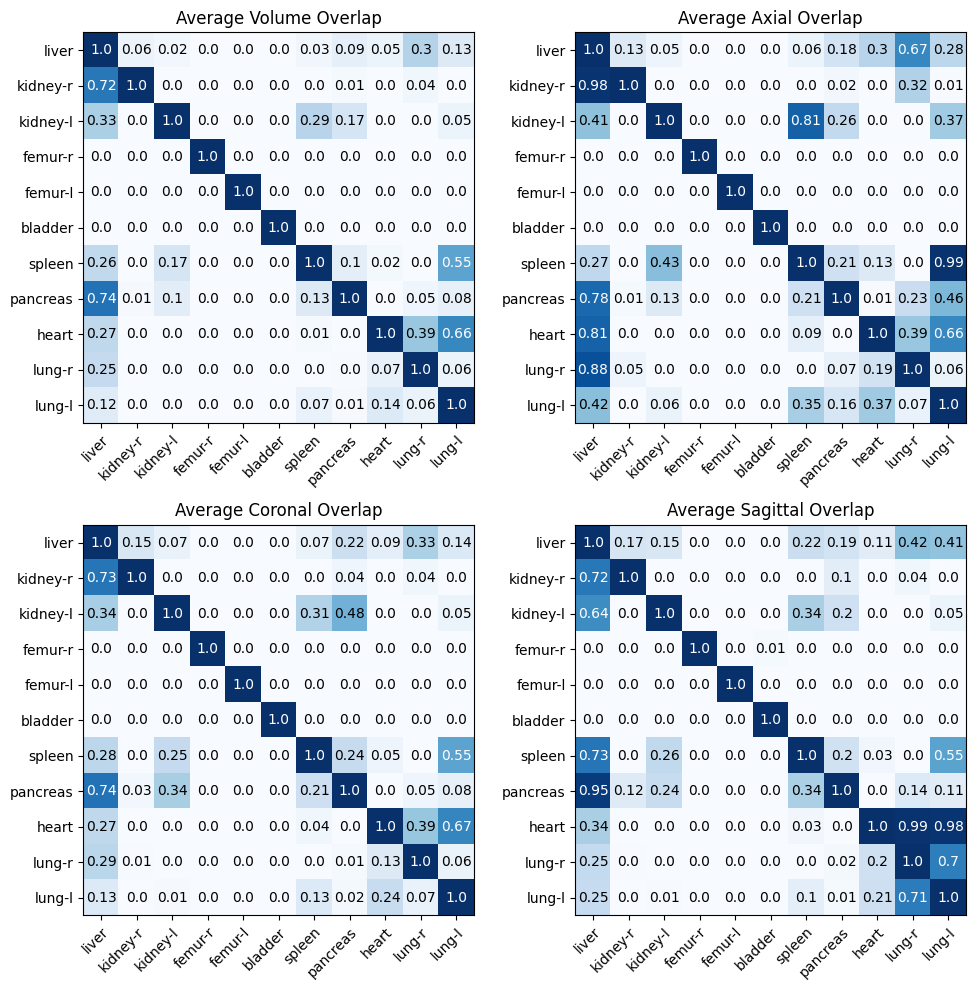

In [4]:
# Get a list of unique organ names
organ_names = df['organ_name'].unique()

# Initialize the confusion matrix
confusion_matrix_vol = np.zeros((len(organ_names), len(organ_names)))
confusion_matrix_axial = np.zeros((len(organ_names), len(organ_names)))
confusion_matrix_coronal = np.zeros((len(organ_names), len(organ_names)))
confusion_matrix_sagittal = np.zeros((len(organ_names), len(organ_names)))
confusion_matrix_counter = np.zeros((len(organ_names), len(organ_names)))
organ_to_idx = {organ_name: i for i, organ_name in enumerate(organ_names)}

# Iterate over each unique image path
for img_path in df['image_path'].unique():
    # Filter the dataframe by image path
    df_img = df[df['image_path'] == img_path]
    # Iterate over each row in the filtered dataframe
    for idx0, row0 in df_img.iterrows():
        for idx1, row1 in df_img.iterrows():
            i = organ_to_idx[row0['organ_name']]
            j = organ_to_idx[row1['organ_name']]
            overlap_x = max(0, min(row0['x1'], row1['x1']) - max(row0['x0'], row1['x0']))
            overlap_y = max(0, min(row0['y1'], row1['y1']) - max(row0['y0'], row1['y0']))
            overlap_z = max(0, min(row0['z1'], row1['z1']) - max(row0['z0'], row1['z0']))
            overlap_vol = (overlap_x * overlap_y * overlap_z) / row0['organ_volume']
            overlap_axial = (overlap_x * overlap_y) / row0['organ_area_axial'] if overlap_z > 0 else 0
            overlap_coronal = (overlap_x * overlap_z) / row0['organ_area_coronal'] if overlap_y > 0 else 0
            overlap_sagittal = (overlap_y * overlap_z) / row0['organ_area_sagittal'] if overlap_x > 0 else 0
            confusion_matrix_vol[i, j] += overlap_vol
            confusion_matrix_axial[i, j] += overlap_axial
            confusion_matrix_coronal[i, j] += overlap_coronal
            confusion_matrix_sagittal[i, j] += overlap_sagittal
            confusion_matrix_counter[i, j] += 1
confusion_matrix_vol = confusion_matrix_vol / confusion_matrix_counter
confusion_matrix_axial = confusion_matrix_axial / confusion_matrix_counter
confusion_matrix_coronal = confusion_matrix_coronal / confusion_matrix_counter
confusion_matrix_sagittal = confusion_matrix_sagittal / confusion_matrix_counter

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax, mat, name in zip(
    axes.flatten(),
    (confusion_matrix_vol, confusion_matrix_axial, confusion_matrix_coronal, confusion_matrix_sagittal),
    ('Volume', 'Axial', 'Coronal', 'Sagittal')
):
    im = ax.imshow(mat, cmap='Blues')
    ax.set_xticks(np.arange(len(organ_names)))
    ax.set_yticks(np.arange(len(organ_names)))
    ax.set_xticklabels(organ_names, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(organ_names)
    plt.setp(ax.get_xticklabels())
    for i in range(len(organ_names)):
        for j in range(len(organ_names)):
            text = ax.text(j, i, round(mat[i][j], 2), ha="center", va="center", color="black" if mat[i][j] < 0.5 else "white")
    ax.set_title(f"Average {name} Overlap")
fig.tight_layout()
fig.savefig('average_overlaps.png')
fig.show()

In [5]:
df['organ_volume/1000'] = df['organ_volume'] / 1000
stats_df = df[['organ_volume/1000', 'organ_name']].groupby('organ_name').agg(
    ['count', 'mean', 'median', 'std']).astype(int)
stats_df

organ_volume/1000                    
                       count   mean median   std
organ_name                                      
bladder                  176    757    499   880
femur-l                  175    145    132    97
femur-r                  171    149    137    98
heart                     81   2200   2272  1258
kidney-l                 199    755    642   510
kidney-r                 200    774    679   538
liver                    201  10039   8304  7076
lung-l                    73  11317  11423  6404
lung-r                    73  12557  12950  6671
pancreas                 201   1150   1025   883
spleen                   201   1375    876  1370